In [356]:
import pandas as pd
import numpy as np
import re
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar los datasets

In [391]:
ds = pd.read_csv(
    'asf_2017-2019.csv',
     encoding='latin-1')

ds_cpi = pd.read_csv('CPI_Mex_full.csv')
ds.head(2)

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1


In [392]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32404 entries, 0 to 32403
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Año Cuenta Pública                32404 non-null  int64 
 1   Grupo Funcional                   32404 non-null  object
 2   Sector                            32404 non-null  object
 3   Ente Fiscalizado                  32404 non-null  object
 4   Entidad Federativa                32404 non-null  object
 5   Tipo Auditoría                    32404 non-null  object
 6   Número                            32404 non-null  int64 
 7   Título                            32404 non-null  object
 8   Universo (miles pesos)            32404 non-null  object
 9   Muestra (miles pesos)             32404 non-null  object
 10  Ente a quien se dirige la Acción  32404 non-null  object
 11  Tipo Acción                       32404 non-null  object
 12  Clave Acción      

In [393]:
ds['Tipo Acción'].unique()

array(['Pliego de Observaciones',
       'Promoción de Responsabilidad Administrativa Sancionatoria', '-',
       'Recomendación', 'Solicitud de Aclaración',
       'Promoción del Ejercicio de la Facultad de Comprobación Fiscal',
       'Informe de Presunta Responsabilidad Administrativa',
       'Denuncia de Hechos',
       'Fincamiento de Responsabilidad Resarcitoria'], dtype=object)

#### Obtener solo los casos de posible corrupcion

In [394]:
ds = ds[ds['Tipo Acción'].isin([
                           'Pliego de Observaciones', 
                           'Promoción de Responsabilidad Administrativa Sancionatoria', 
                           'Informe de Presunta Responsabilidad Administrativa',
                           'Promoción del Ejercicio de la Facultad de Comprobación Fiscal'])
]

In [395]:
print(len(ds))
ds = ds[(ds['Acciones'] > 0) | (ds['Acciones'].isna())]
print(len(ds))

21606
21606


In [397]:
ds['terminado'] = ds['Estado de Trámite'].isin(['Con seguimiento concluido','Conclusión'])
ds.head(2)

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones,desaparecido,terminado
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1,1.342933e+09,False
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,NaN,True


In [413]:
ds = ds.drop(['Número', 'Clave Acción', 'Acción Superveniente', 
              'Grupo Funcional', 'Estado de Trámite', 
              'Auditorías', 'Acciones'],
        axis=1)

KeyError: "['Número' 'Clave Acción' 'Acción Superveniente' 'Grupo Funcional'\n 'Estado de Trámite' 'Auditorías' 'Acciones'] not found in axis"

In [421]:
def get_money(text):

  if pd.isna(text):
    
    
    
    
    
    return np.nan
  re_dinero = re.compile(r'monto de ([\d|,|\.]+) pesos')
  res = re_dinero.search(text)
  if res:
    re_num = re.compile(r'[^0-9]')
    return float(re.sub(re_num, '', res.groups()[0][:-3]))
  return np.nan

In [423]:
ds['desaparecido'] = ds['Texto Acción'].apply(get_money)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21606 entries, 0 to 32397
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Año Cuenta Pública                21606 non-null  int64  
 1   Sector                            21606 non-null  object 
 2   Ente Fiscalizado                  21606 non-null  object 
 3   Entidad Federativa                21606 non-null  object 
 4   Tipo Auditoría                    21606 non-null  object 
 5   Título                            21606 non-null  object 
 6   Universo (miles pesos)            21606 non-null  object 
 7   Muestra (miles pesos)             21606 non-null  object 
 8   Ente a quien se dirige la Acción  21606 non-null  object 
 9   Tipo Acción                       21606 non-null  object 
 10  Texto Acción                      17841 non-null  object 
 11  desaparecido                      5724 non-null   float64
 12  term

In [427]:
set(ds_cpi['estado'].unique())

{'Aguascalientes',
 'Baja California',
 'Baja California Sur',
 'Campeche',
 'Chiapas',
 'Chihuahua',
 'Ciudad de México',
 'Coahuila de Zaragoza',
 'Colima',
 'Durango',
 'Estado de México',
 'Guanajuato',
 'Guerrero',
 'Hidalgo',
 'Jalisco',
 'Michoacán',
 'Morelos',
 'Nayarit',
 'Nuevo León',
 'Oaxaca',
 'Puebla',
 'Querétaro',
 'Quintana Roo',
 'San Luis Potosí',
 'Sinaloa',
 'Sonora',
 'Tabasco',
 'Tamaulipas',
 'Tlaxcala',
 'Veracruz',
 'Yucatán',
 'Zacatecas'}

In [428]:
# {'Michoacán de Ocampo', 'México', 'Veracruz Ignacio de la Llave'}
def renom_estados(name):
  estados = {
    'Michoacán de Ocampo': 'Michoacán', 
    'México': 'Estado de México', 
    'Veracruz Ignacio de la Llave': 'Veracruz'}

  if name in estados:
    return estados[name]
  
  return name

ds['Entidad Federativa'] = ds['Entidad Federativa'].map(renom_estados)

In [429]:
estados_corrupt = set(ds['Entidad Federativa'].unique())
estados_corrupt.difference(set(ds_cpi['estado'].unique()))

set()

In [430]:
print(len(ds['Entidad Federativa'].unique()) / len(ds_cpi['estado'].unique()) * 100, 
'% de los estados')

100.0 % de los estados


### Dataset terminado

In [431]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21606 entries, 0 to 32397
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Año Cuenta Pública                21606 non-null  int64  
 1   Sector                            21606 non-null  object 
 2   Ente Fiscalizado                  21606 non-null  object 
 3   Entidad Federativa                21606 non-null  object 
 4   Tipo Auditoría                    21606 non-null  object 
 5   Título                            21606 non-null  object 
 6   Universo (miles pesos)            21606 non-null  object 
 7   Muestra (miles pesos)             21606 non-null  object 
 8   Ente a quien se dirige la Acción  21606 non-null  object 
 9   Tipo Acción                       21606 non-null  object 
 10  Texto Acción                      17841 non-null  object 
 11  desaparecido                      5724 non-null   float64
 12  term

In [409]:
print('NA por columna', list(map(lambda col: ds[col].isna().sum(),
    list(ds.columns))),
    '\n')

print(ds.columns)

NA por columna [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3765, 15882, 0] 

Index(['Año Cuenta Pública', 'Sector', 'Ente Fiscalizado',
       'Entidad Federativa', 'Tipo Auditoría', 'Título',
       'Universo (miles pesos)', 'Muestra (miles pesos)',
       'Ente a quien se dirige la Acción', 'Tipo Acción', 'Texto Acción',
       'desaparecido', 'terminado'],
      dtype='object')


In [410]:
ds.head(2)

,Año Cuenta Pública,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Texto Acción,desaparecido,terminado
0,2019,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,"Se presume un probable daño o perjuicio, o amb...",1.342933e+09,False
1,2019,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,La Auditoría Superior de la Federación emite l...,NaN,True


In [411]:
ds_cpi.head(2)

,estado,municipio,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,...,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
0,Aguascalientes,Aguascalientes,73.28,27.92,99.02,68.10,69.72,62.83,43.60,49.45,...,96.51,70.12,62.34,61.71,46.15,80.00,43.44,99.99,95.80,54.65
1,Aguascalientes,Jesús María,38.22,32.03,97.96,70.14,60.84,56.75,20.87,53.62,...,95.74,81.23,59.62,72.67,49.71,67.03,54.10,100.00,93.98,38.73


## Cantidad de dinero por estado

In [414]:
# agrupado = 
dinero_por_estado = ds.dropna(subset=['desaparecido'], how='any').groupby(['Entidad Federativa'])['desaparecido'].aggregate(['sum', 'count'])
dinero_por_estado = dinero_por_estado.reset_index()
dinero_por_estado['dinero_segun_auditorias'] = dinero_por_estado['sum'] / dinero_por_estado['count']
dinero_por_estado

,Entidad Federativa,sum,count,dinero_segun_auditorias
0,Aguascalientes,1.865944e+09,117,1.594824e+07
1,Baja California,1.714967e+09,126,1.361085e+07
2,Baja California Sur,2.942302e+09,169,1.741007e+07
3,Campeche,1.248247e+09,128,9.751928e+06
4,Chiapas,1.184274e+10,374,3.166508e+07
5,Chihuahua,5.465822e+09,146,3.743714e+07
6,Ciudad de México,3.087561e+10,391,7.896574e+07
7,Coahuila de Zaragoza,6.792463e+09,332,2.045923e+07
8,Colima,1.561771e+09,145,1.077083e+07
9,Durango,1.525609e+09,95,1.605904e+07


In [417]:
ds_primero_agrupado

,count
Entidad Federativa,
Aguascalientes,279
Baja California,606
Baja California Sur,527
Campeche,346
Chiapas,799
Chihuahua,505
Ciudad de México,1592
Coahuila de Zaragoza,697
Colima,346


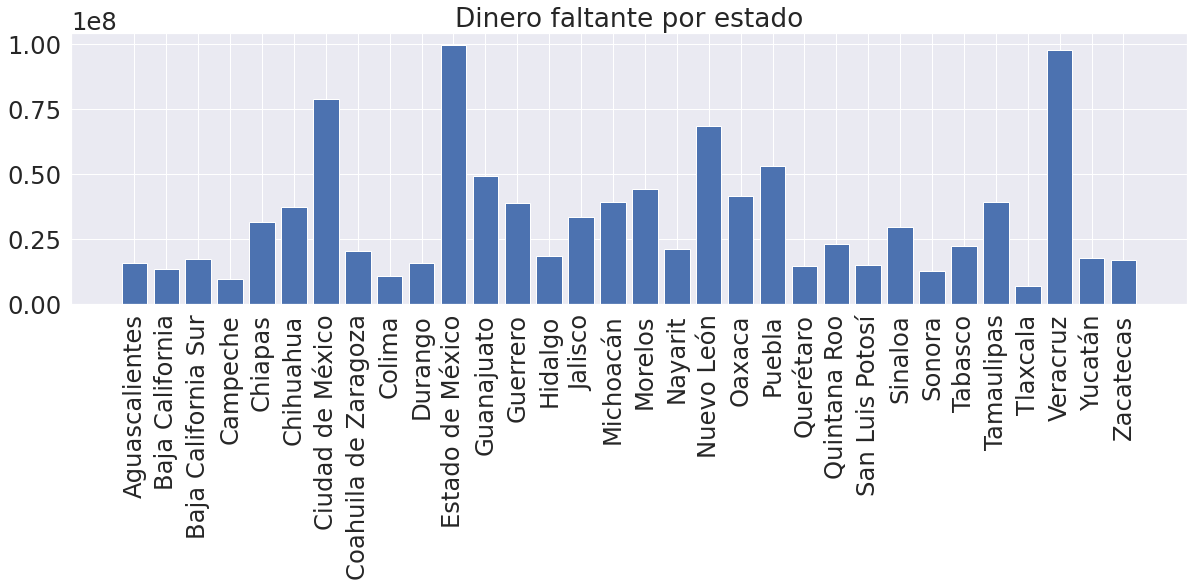

In [418]:
fig, axs = plt.subplots(figsize=(20,5))
axs.bar(dinero_por_estado['Entidad Federativa'], dinero_por_estado['dinero_segun_auditorias'])
plt.xticks(rotation=90)
plt.title('Dinero faltante por estado')

plt.show()

##### CPI por estado

In [555]:
ds_cpi_reducido =  ds_cpi[
                          list(filter(
                              lambda cl: cl == cl.upper(),
                              ds_cpi.columns)) + ['estado']]
ds_cpi_reducido = ds_cpi_reducido.set_index('estado').join(dinero_por_estado.set_index('Entidad Federativa')).reset_index().rename(columns={'index':'estado'})
ds_cpi_reducido.head(20)

,estado,CALIDAD DE VIDA,EQUIDAD E INCLUSIÓN SOCIAL,GOBERNANZA Y LEGISLACIÓN URBANA,INFRAESTRUCTURA DE DESARROLLO,PRODUCTIVIDAD,SOSTENIBILIDAD AMBIENTAL,sum,count,dinero_segun_auditorias
0,Aguascalientes,69.72,72.49,29.10,64.85,61.48,34.77,1.865944e+09,117,1.594824e+07
1,Aguascalientes,60.84,73.72,56.84,52.60,66.37,69.97,1.865944e+09,117,1.594824e+07
2,Aguascalientes,62.71,72.67,29.81,51.66,63.78,30.70,1.865944e+09,117,1.594824e+07
3,Baja California,54.24,72.79,42.42,56.56,54.44,76.70,1.714967e+09,126,1.361085e+07
4,Baja California,59.45,74.23,29.64,57.87,59.08,77.69,1.714967e+09,126,1.361085e+07
5,Baja California,52.26,74.27,30.31,49.31,52.41,65.43,1.714967e+09,126,1.361085e+07
6,Baja California,58.58,77.21,56.29,52.55,57.71,41.60,1.714967e+09,126,1.361085e+07
7,Baja California,58.05,72.66,59.53,57.15,64.28,34.72,1.714967e+09,126,1.361085e+07
8,Baja California Sur,64.22,72.85,71.32,74.05,60.26,46.92,2.942302e+09,169,1.741007e+07
9,Baja California Sur,55.58,71.21,49.50,66.66,66.20,47.28,2.942302e+09,169,1.741007e+07


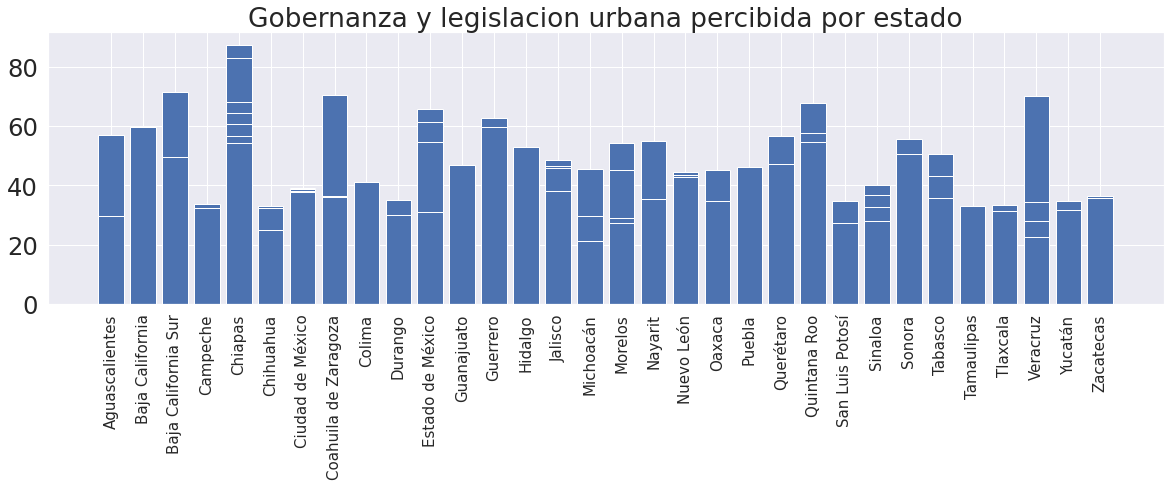

In [420]:
fig, axs = plt.subplots(figsize=(20,5))
axs.bar(ds_cpi_reducido['estado'], ds_cpi_reducido['GOBERNANZA Y LEGISLACIÓN URBANA'])
plt.xticks(fontsize= 15, rotation=90)
plt.title('Gobernanza y legislacion urbana percibida por estado')

plt.show()

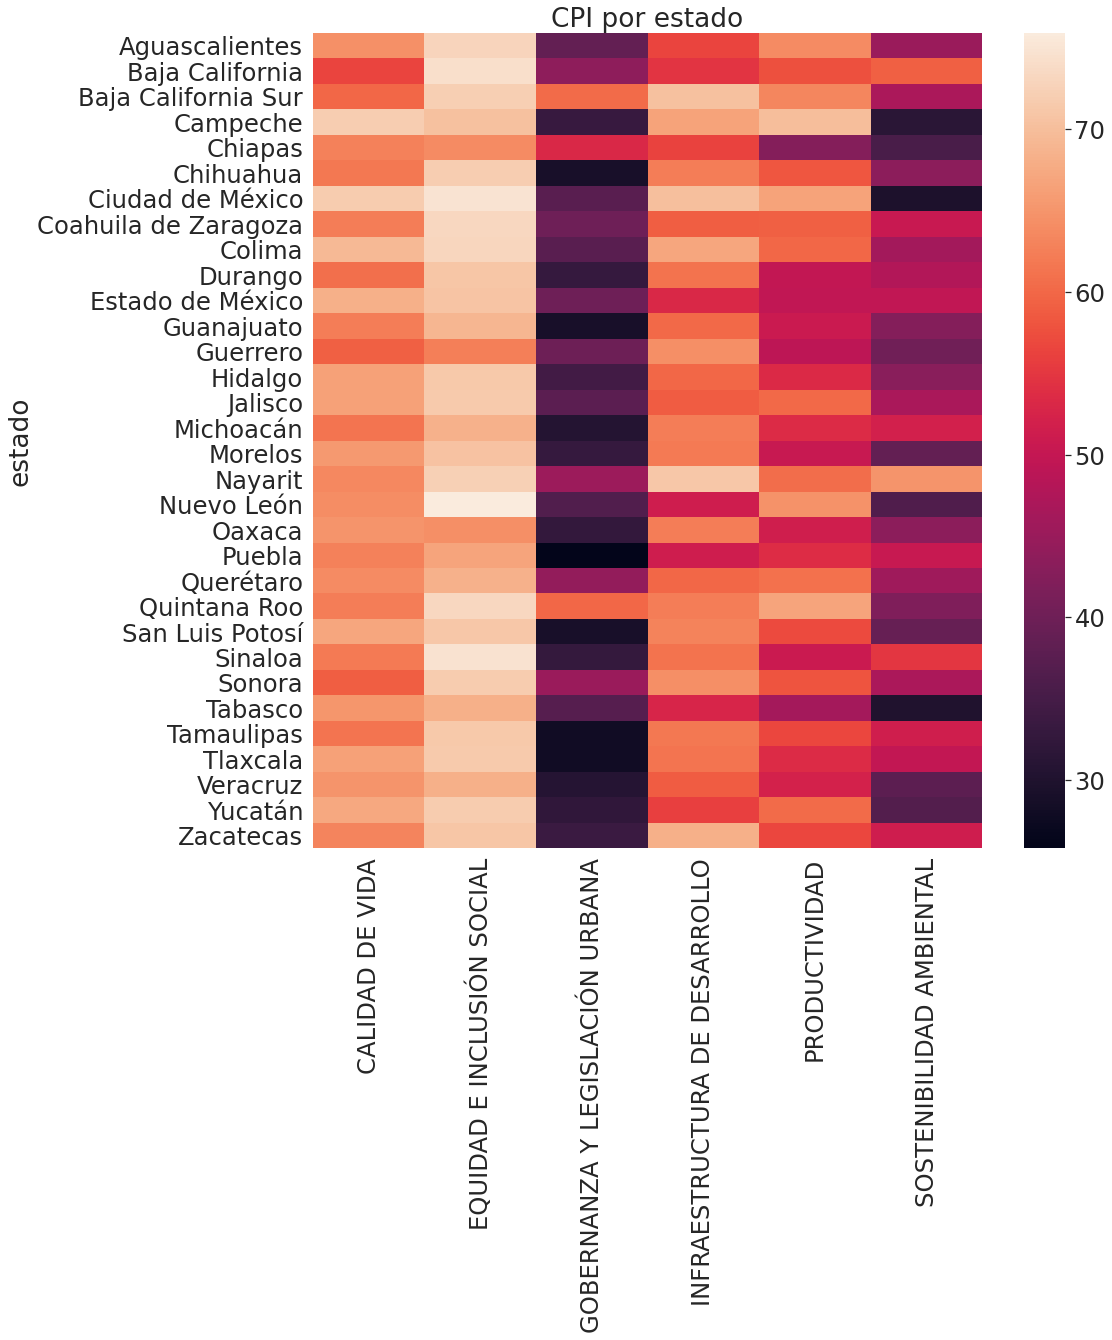

In [422]:
import seaborn as sns
import pandas as pd
import numpy as np

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, )
# fig.xticks(rotation=45)
plt.title('CPI por estado')
p1 = sns.heatmap(
    ds_cpi_reducido.groupby('estado').mean().drop(['dinero_segun_auditorias', 'sum', 'count'], axis=1),
    ax=ax)

[Text(0.5, 0, 'Numero auditorias')]

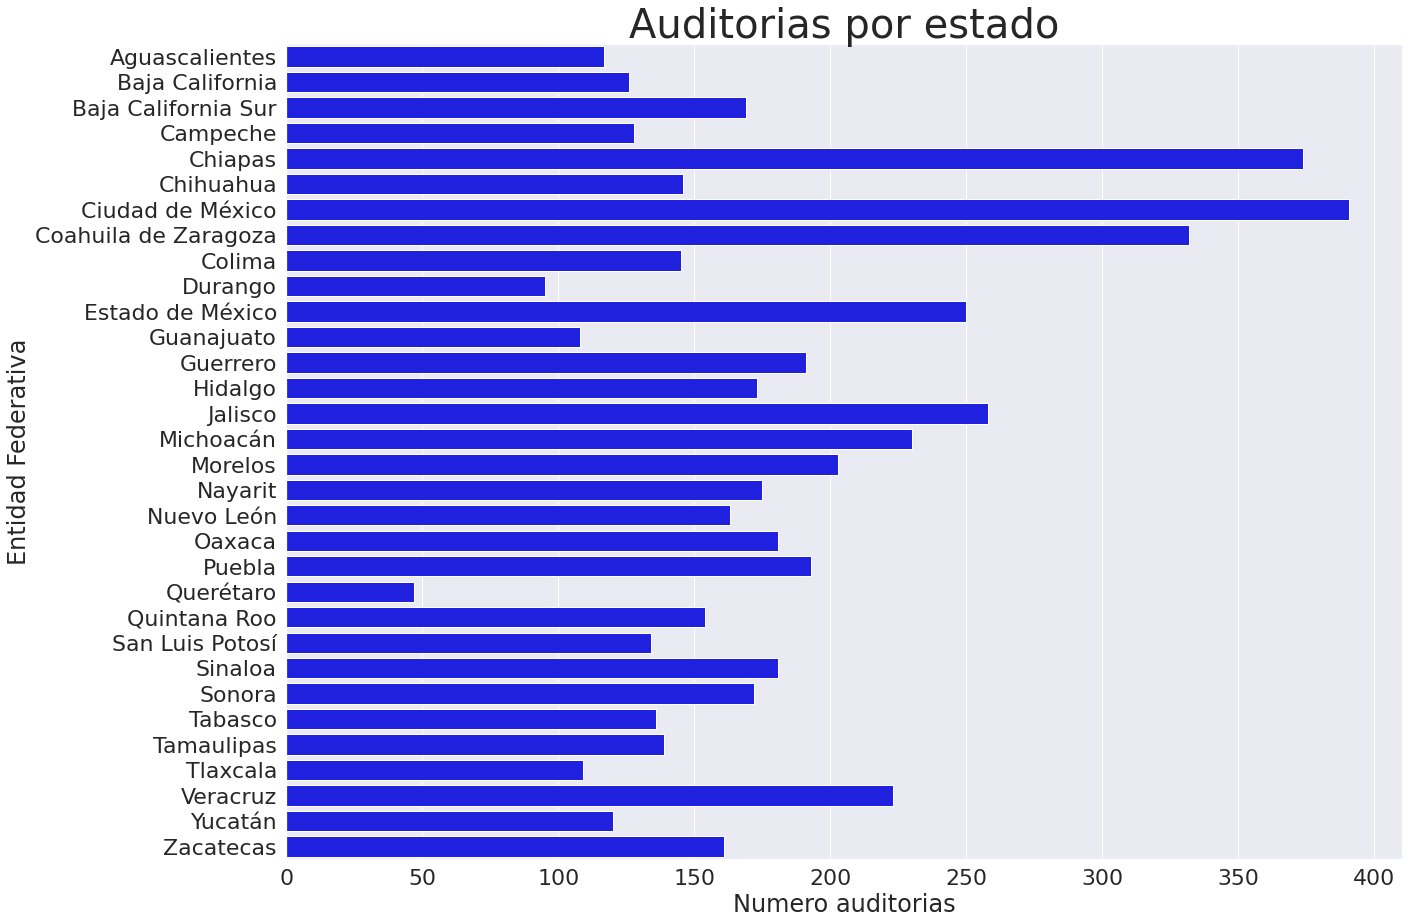

In [426]:
plt.figure(figsize=(20,15))
plt.title("Auditorias por estado",fontsize=40)
sns.set(font_scale=2.2)
ax = sns.barplot(y="Entidad Federativa", x="count", data = dinero_por_estado,
            color="blue")
ax.set(xlabel='Numero auditorias')

### Porcentaje de incidencia

In [432]:
ds_incidencia = pd.read_csv(
    'asf_2017-2019.csv',
     encoding='latin-1')

ds_incidencia = ds_incidencia[ds_incidencia['Tipo Auditoría'] != 'Forense']

print(ds_incidencia['Sector'].unique())
ds_incidencia.shape

['Aportaciones A Seguridad Social' 'Bienestar'
 'Desarrollo Agrario, Territorial y Urbano' 'Educación Pública'
 'Entidades No Sectorizadas' 'Gobernación' 'Hacienda y Crédito Público'
 'Instituciones Públicas de Educación Superior'
 'Medio Ambiente y Recursos Naturales'
 'Previsiones y Aportaciones Para Los Sistemas de Educación Básica, Normal, Tecnológica y de Adultos'
 'Ramos Generales 23, 33 y Otros' 'Salud'
 'Seguridad y Protección Ciudadana' 'Cultura'
 'Empresas Productivas Del Estado' 'Función Pública' 'Turismo']


(32332, 18)

Se descartan todas las auditorias incompletas o invalidas para este estudio
#### Casos de auditorias terminadas y validas

In [433]:
ds_incidencia = ds_incidencia[~ds_incidencia['Estado de Trámite'].isin([
    '-', np.nan, 'No Notificado', 'Sustituida por Nueva Acción', 
    'Sobreseimiento'
])]

print(ds_incidencia.shape[0], 'casos validos')

25683 casos validos


Obtenemos las auditorias que presentaron casos de posible corrupcion

In [434]:
ds_incidencia['incidencia'] = \
    ds_incidencia['Tipo Acción'].isin([
        'Pliego de Observaciones', 
        'Promoción de Responsabilidad Administrativa Sancionatoria', 
        'Informe de Presunta Responsabilidad Administrativa',
        'Promoción del Ejercicio de la Facultad de Comprobación Fiscal']) &\
    (~ds_incidencia['Texto Acción'].isna()) &\
    (ds_incidencia['Texto Acción'] != '-')

ds_incidencia.head()
print(ds_incidencia['incidencia'].sum(), 'casos de posible corrupcion')

17803 casos de posible corrupcion


#### Porcentaje de incidencia resultante

In [435]:
print(
    'El porcentaje de incidencia encontrado en auditorias de la ASF es de',
    round((ds_incidencia['incidencia'].sum()/ds_incidencia.shape[0]) * 100),
    '%'
)

El porcentaje de incidencia encontrado en auditorias de la ASF es de 69 %


### Datasets de uso comun

In [704]:
ds_dinero = ds.dropna(subset=['desaparecido'], how='any')

# Preguntas

Cuanto dinero perdido tenemos actualmente?

In [441]:
assert ds['desaparecido'].sum() == dinero_por_estado["sum"].sum()

print(
    'Existe un total de:',
    "${:,.2f}".format(dinero_por_estado["sum"].sum()),
    'pesos mexicanos desaparecidos en el periodo del 2014 al 2019.'
)

Existe un total de: $215,760,701,632.00 pesos mexicanos desaparecidos en el periodo del 2014 al 2019.


- Existe una relacion entre la cantidad de dinero perdido de un estado y su CPI?
- La relacion entre en la corrupcion y el CPI es positiva o negativa?
- Cuales son los estados con peor manejo de recursos
- Como varia el mal manejo de los recursos con respecto al tiempo
- Cuales son las organizaciones gubernamentales con peor manejo de los recursos publicos
- Cuales son los sectores peor administrados
- Existe alguna relacion entre el sector y eficiencia de la resolucion de las auditorias?
- Cual es el sector y la entidad federativa mas auditada

## Cuales son los estados con peor manejo de recursos

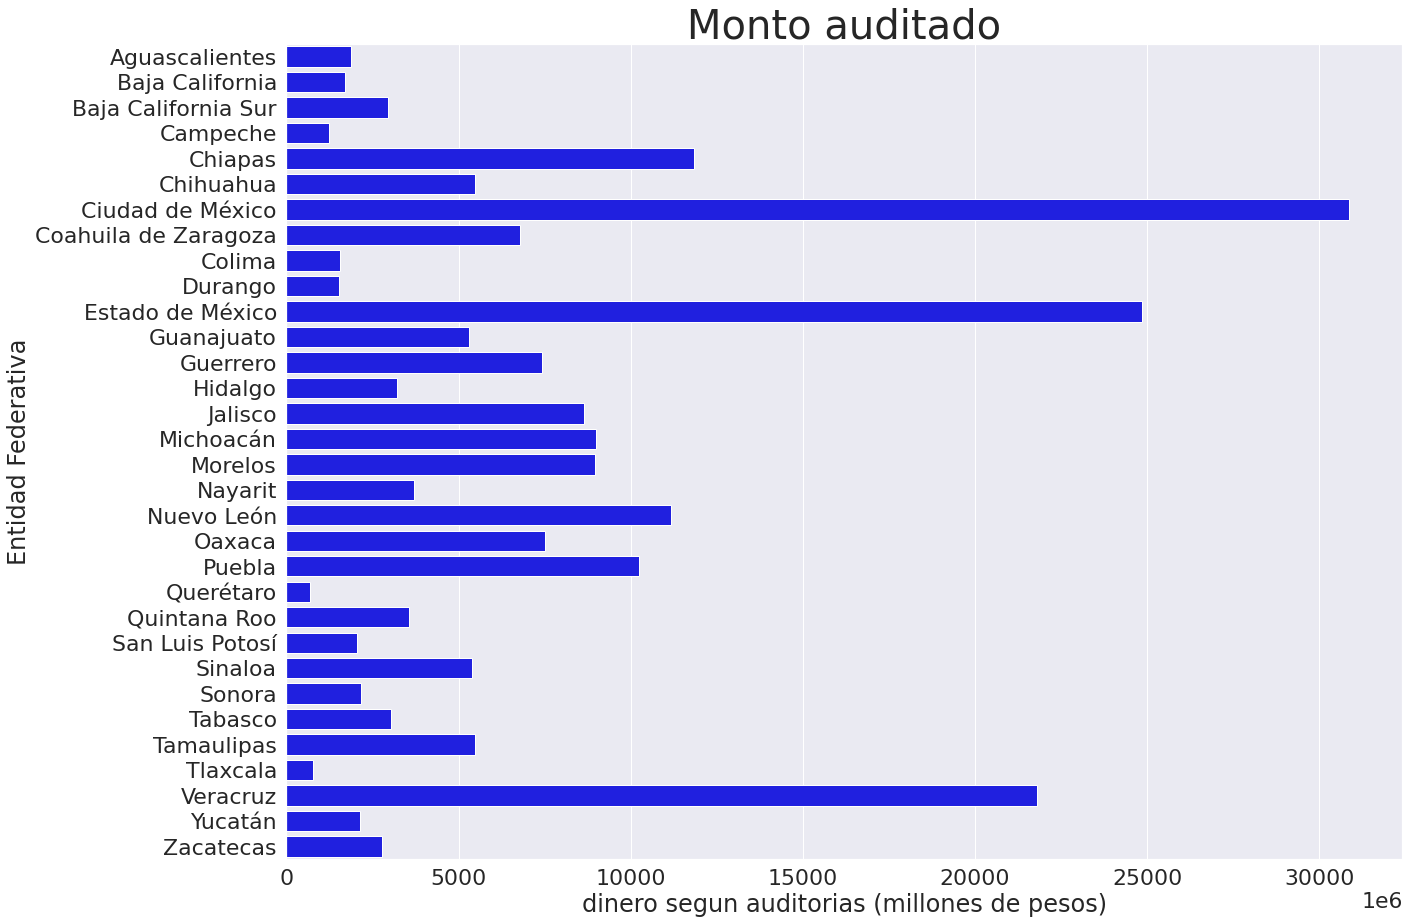

In [738]:
plt.figure(figsize=(20,15))
plt.title("Monto auditado",fontsize=40)
sns.set(font_scale=2)
ax = sns.barplot(y="Entidad Federativa", x="sum", data = dinero_por_estado,color = "blue"
            )
ax.set(xlabel = 'dinero segun auditorias (millones de pesos)')
ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))

Dado que en el grafico únicamente se considera el monto que se mocharon, se decidió normalizar el monto mochado respecto al número de auditorias realizadas para el estado, para así revelar información que pudiese estar enmascarada por este hecho

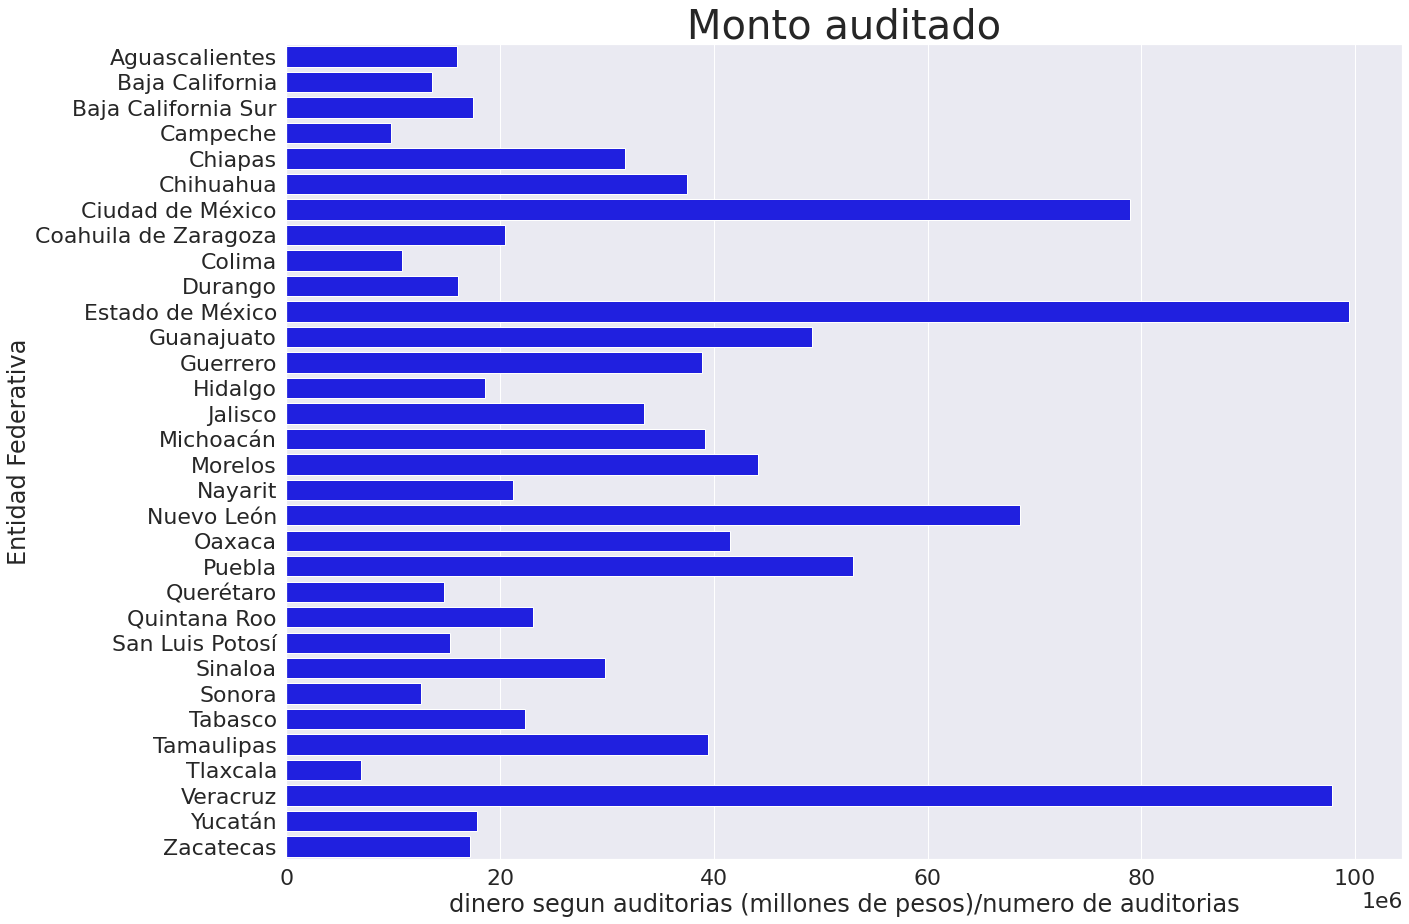

In [703]:
aiuda = dinero_por_estado.sort_values(by = "count")
plt.figure(figsize=(20,15))
plt.title("Monto auditado",fontsize=40)
sns.set(font_scale=2)
ax = sns.barplot(y="Entidad Federativa", x="dinero_segun_auditorias", data = dinero_por_estado, color = "blue"
            )
ax.set(xlabel = 'dinero segun auditorias (millones de pesos)/numero de auditorias')
ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))

Con este gráfico podemos observar que los estados que más dinero se mocharon son:
- Estado de México
- Veracruz
- Ciudad de México
- Nuevo León
- Puebla

## Como varia el mal manejo de los recursos con respecto al tiempo

Para este análisis se consideraró, de la misma manera, el total de dinero mochado dividido por el numero de auditorias por año.

Se discutirán los estados que a nivel nacional son los que presentan un mayor moche de dinero

In [641]:
ds_tiempo = ds.dropna(subset=['desaparecido'], how='any').groupby(['Entidad Federativa','Año Cuenta Pública'])['desaparecido'].aggregate(['sum', 'count'])
ds_tiempo = ds_tiempo.reset_index()
ds_tiempo['dinero_por_auditoria'] = ds_tiempo['sum']/ds_tiempo['count']
ds_tiempo.head(5)

,Entidad Federativa,Año Cuenta Pública,sum,count,dinero_por_auditoria
0,Aguascalientes,2014,1.498536e+08,11,1.362306e+07
1,Aguascalientes,2015,1.335622e+06,1,1.335622e+06
2,Aguascalientes,2016,2.490442e+08,31,8.033683e+06
3,Aguascalientes,2017,5.225548e+07,6,8.709246e+06
4,Aguascalientes,2018,1.188667e+09,49,2.425851e+07


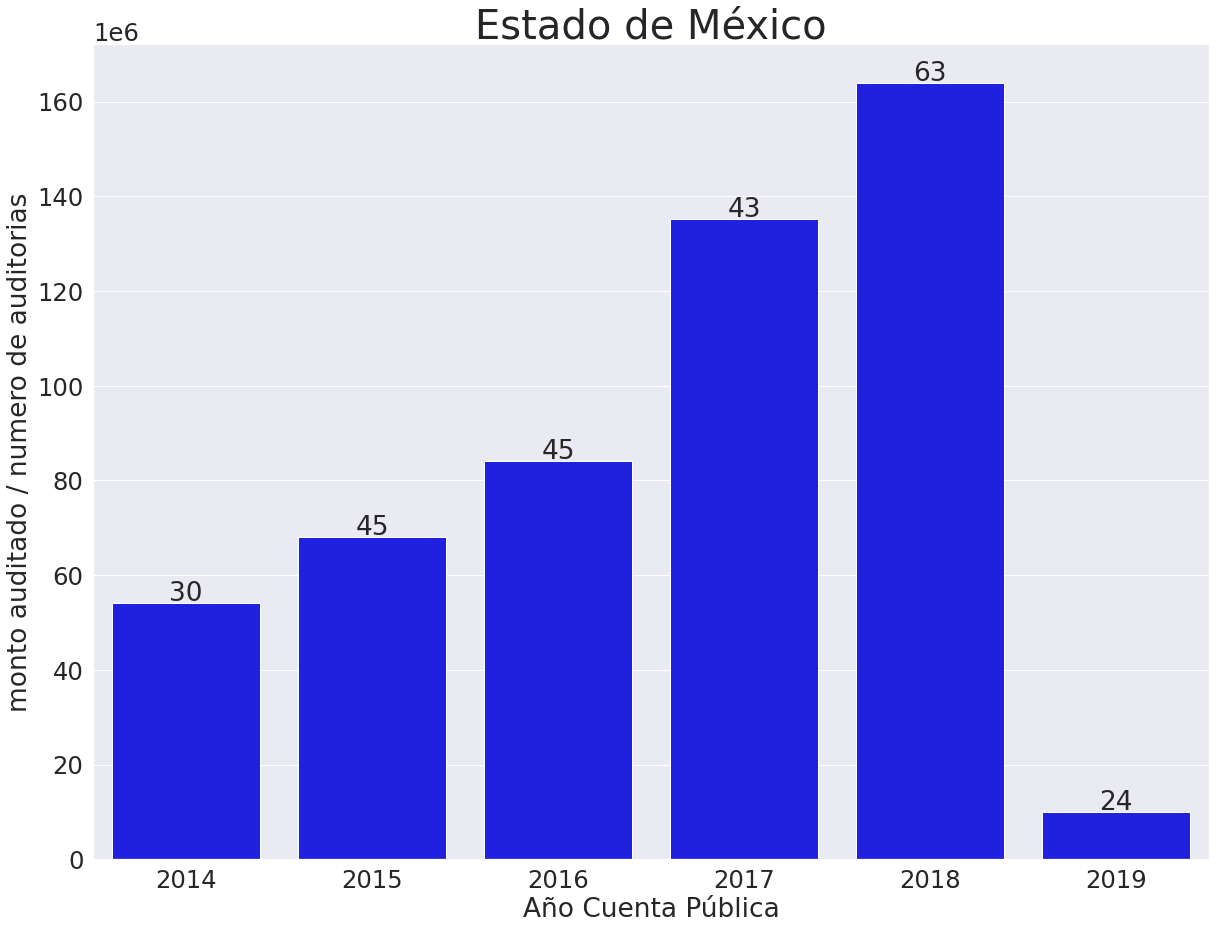

In [796]:
estado = "Estado de México"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

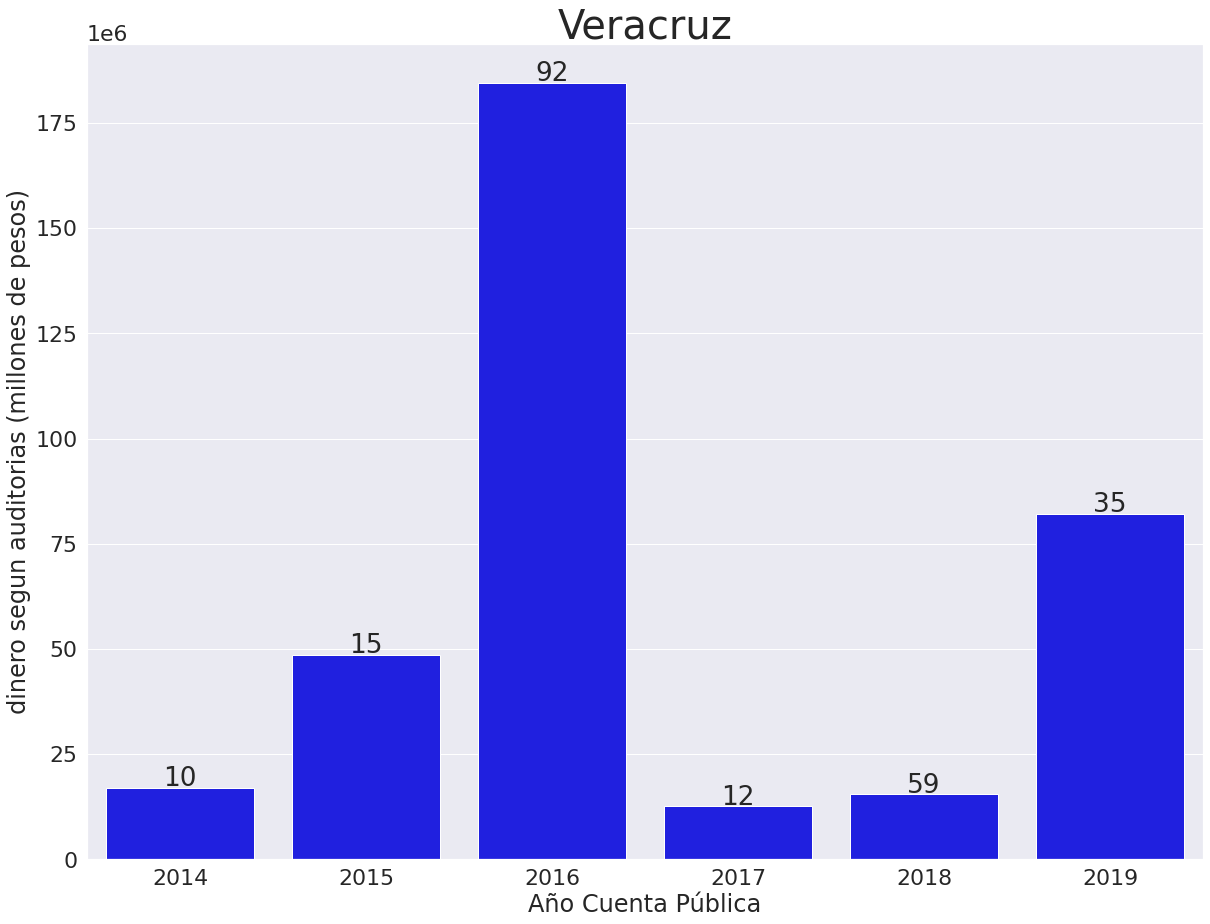

In [788]:
estado = "Veracruz"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

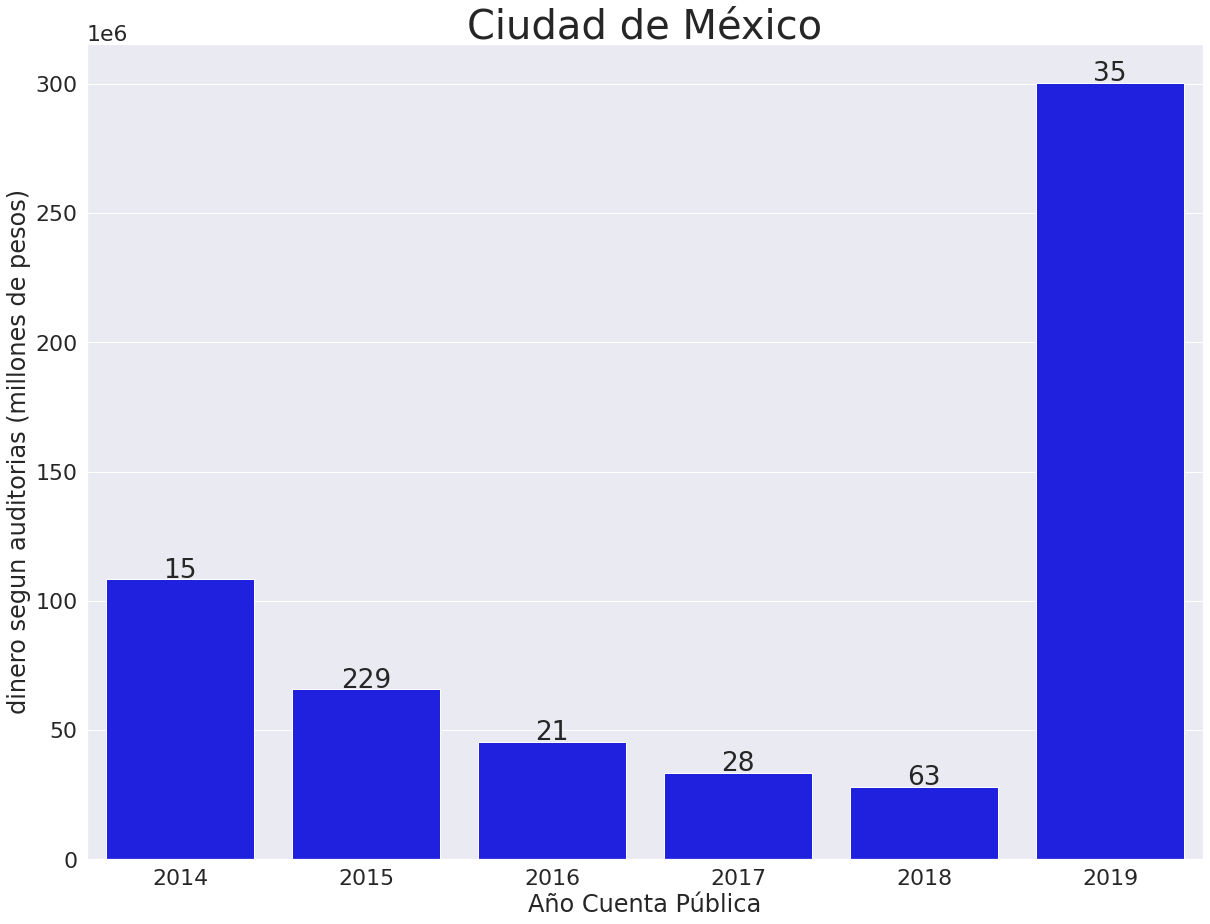

In [773]:
estado = "Ciudad de México"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

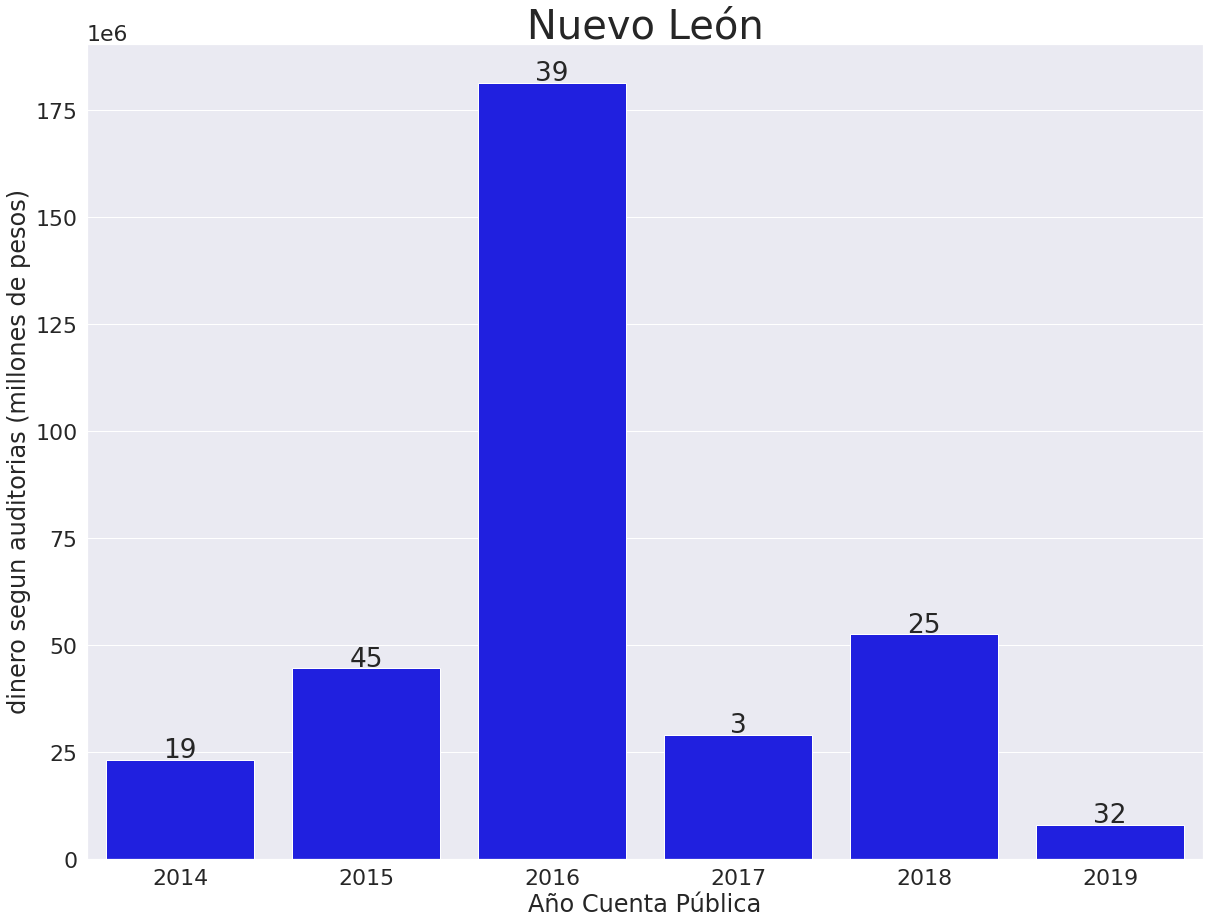

In [791]:
estado = "Nuevo León"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

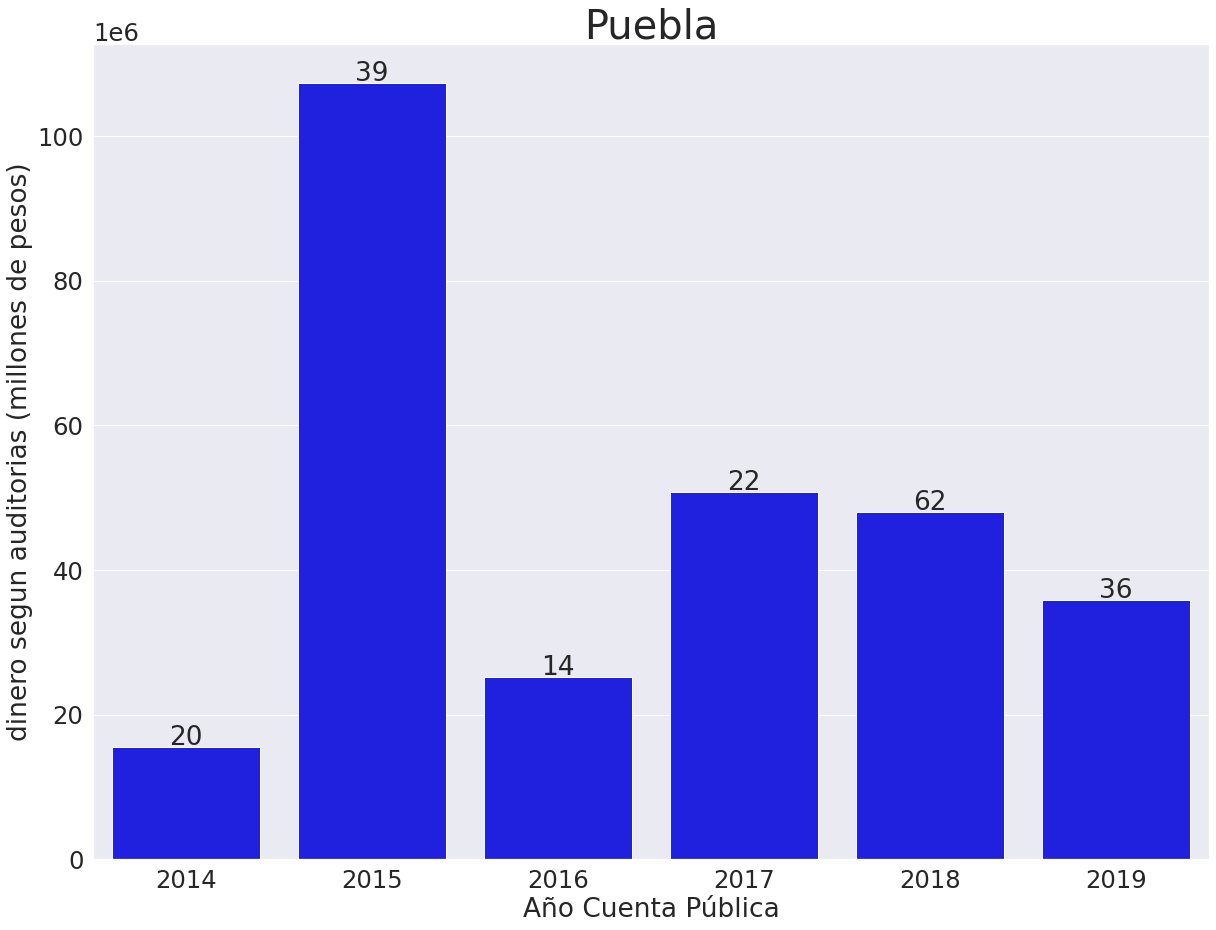

In [792]:
estado = "Puebla"
plt.figure(figsize=(20,15))
plt.title(estado,fontsize=40)
sns.set(font_scale=2.2)

ax = sns.barplot(x="Año Cuenta Pública", y="dinero_por_auditoria", data = ds_tiempo[ds_tiempo['Entidad Federativa'] == estado],
            color="blue",)
ax.set(ylabel = 'monto auditado / numero de auditorias')
ax.ticklabel_format(axis="y", style = "sci",scilimits = (6,6))
i=0
for p in ax.patches:
    ax.annotate(ds_tiempo[ds_tiempo['Entidad Federativa'] == estado]['count'].values[i], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i+=1
# ax.set(xlabel='Numero auditorias')
plt.savefig(estado+".png")

### Discusion

Se observa como 

## - Existe una relacion entre la cantidad de dinero perdido de un estado y su CPI?,  La relacion entre en la corrupcion y el CPI es positiva o negativa?


In [822]:
# REDUCIDO POR SECTORES DEL CPI

## Usando la media, mediana, valor máximo o mínimo de cada estado
ds_cpi_reducido_corr=ds_cpi_reducido #.groupby('estado').mean()
ds_cpi_reducido_corr.drop(["count"], axis=1, inplace=True)

## Matriz de correlación
corr_mat = ds_cpi_reducido_corr.corr()
corr_mat

,CALIDAD DE VIDA,EQUIDAD E INCLUSIÓN SOCIAL,GOBERNANZA Y LEGISLACIÓN URBANA,INFRAESTRUCTURA DE DESARROLLO,PRODUCTIVIDAD,SOSTENIBILIDAD AMBIENTAL,sum,dinero_segun_auditorias
CALIDAD DE VIDA,1.000000,0.119677,0.096830,0.054866,-0.020260,-0.046501,0.371003,0.296489
EQUIDAD E INCLUSIÓN SOCIAL,0.119677,1.000000,-0.121311,0.149755,0.362585,0.191016,0.052018,0.042722
GOBERNANZA Y LEGISLACIÓN URBANA,0.096830,-0.121311,1.000000,-0.059342,-0.079957,-0.077338,0.063513,-0.055251
INFRAESTRUCTURA DE DESARROLLO,0.054866,0.149755,-0.059342,1.000000,0.290803,-0.026446,-0.100310,-0.211233
PRODUCTIVIDAD,-0.020260,0.362585,-0.079957,0.290803,1.000000,0.022934,-0.056736,-0.092669
SOSTENIBILIDAD AMBIENTAL,-0.046501,0.191016,-0.077338,-0.026446,0.022934,1.000000,-0.070234,-0.014923
sum,0.371003,0.052018,0.063513,-0.100310,-0.056736,-0.070234,1.000000,0.912085
dinero_segun_auditorias,0.296489,0.042722,-0.055251,-0.211233,-0.092669,-0.014923,0.912085,1.000000


In [784]:
# PARA TODOS LOS SECTORES INDIVIDUALES DEL CPI

columnas_cpi=list(ds_cpi.columns)
columnas_cpi.pop(0)
columnas_cpi.pop(0)
dic_corr={}
for i in columnas_cpi:
    dic_corr[i]=ds_cpi[i].corr(ds_cpi_reducido["dinero_segun_auditorias"])  #sum
dic_corr=sorted(dic_corr.items(), key=lambda x: x[1], reverse=True)
dic_corr

[('Densidad poblacional', 0.30738415260047086),
 ('CALIDAD DE VIDA', 0.29648908223314613),
 ('Coeﬁciente de Gini', 0.20799111563704256),
 ('Áreas verdes per cápita', 0.18662828487631483),
 ('Acceso a Internet', 0.09252234448012703),
 ('Espacio habitable suﬁciente', nan),
 ('Esperanza de vida al nacer', 0.19666844024516755),
 ('Seguridad y protección', 0.18650010693814228),
 ('Tasa de homicidios', 0.18650010693814228),
 ('Salud', 0.18188646165561875),
 ('Espacio público', 0.17538717630318904),
 ('Infraestructura de vivienda', 0.17204963909666274),
 ('Velocidad de banda ancha promedio', 0.15722445750106634),
 ('Tasa de mortalidad de menores de 5 años', 0.14945375468444047),
 ('Infraestructura de comunicaciones', 0.14164108771687572),
 ('Recolección de residuos sólidos', 0.11431551922523556),
 ('Participación electoral', 0.0869468761337527),
 ('Participación y rendición de cuentas', 0.0869468761337527),
 ('Inclusión de género', 0.07799504175901258),
 ('Inscripción equitativa en educación 

## Cuales son las organizaciones gubernamentales con peor manejo de los recursos publicos?


In [719]:
ds_org = ds_dinero.groupby('Ente a quien se dirige la Acción')
ds_org = ds_org['desaparecido'].aggregate(['count', 'sum', 'mean'])
ds_org = ds_org.reset_index()
ds_org.head(5)

,Ente a quien se dirige la Acción,count,sum,mean
0,"Alcaldía Benito Juárez, Ciudad de México",1,6109360.0,6109360.0
1,"Alcaldía Cuajimalpa de Morelos, Ciudad de México",1,1348454.0,1348454.0
2,"Alcaldía Cuauhtémoc, Ciudad de México",4,24563850.0,6140962.5
3,"Alcaldía Gustavo A. Madero, Ciudad de México",5,305781671.0,61156334.2
4,"Alcaldía Iztacalco, Ciudad de México",1,37036.0,37036.0


In [776]:
ds_top_99 = ds_org[ds_org['mean'] >= ds_org['mean'].quantile(.99)]
ds_top_99

,Ente a quien se dirige la Acción,count,sum,mean
46,Instituto Mexicano del Seguro Social,1,1.342933e+09,1.342933e+09
238,"Municipio de León, Guanajuato",5,2.319774e+09,4.639549e+08
358,"Municipio de San Pedro Garza García, Nuevo León",1,3.884771e+08,3.884771e+08
482,Secretaría de Salud,2,1.339713e+09,6.698563e+08
486,"Televisora de Hermosillo, S. A. de C. V.",1,2.718917e+08,2.718917e+08
493,Universidad Autónoma de Chihuahua,3,8.268089e+08,2.756030e+08


[Text(0.5, 0, 'dinero promedio por auditoria (miles de millones)')]

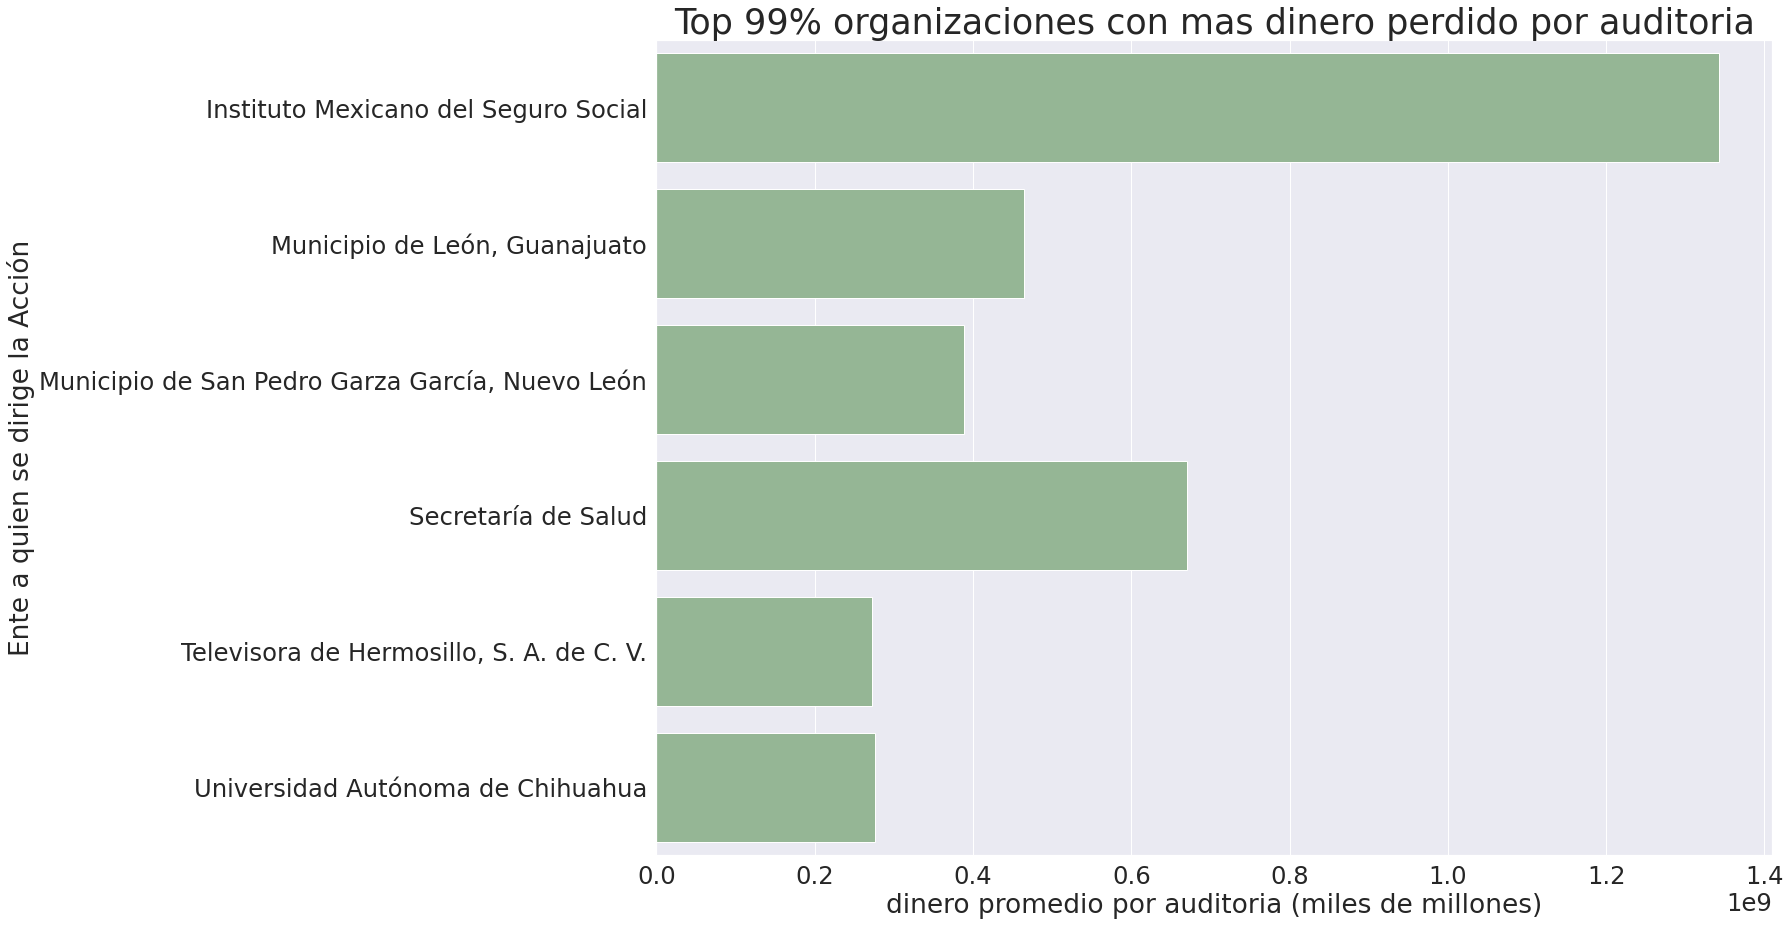

In [777]:
plt.figure(figsize=(20,15))
plt.title("Top 99% organizaciones con mas dinero perdido por auditoria",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Ente a quien se dirige la Acción", x="mean", data = ds_top_99, color = "darkseagreen")
ax.set(xlabel = 'dinero promedio por auditoria (miles de millones)')
# ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))

In [801]:
ds_top_99 = ds_org[ds_org['count'] >= ds_org['count'].quantile(.99)]
ds_top_99.head()

,Ente a quien se dirige la Acción,count,sum,mean
19,Gobierno del Estado de Chiapas,234,9.773112e+09,4.176543e+07
21,Gobierno del Estado de Coahuila de Zaragoza,173,5.899674e+09,3.410216e+07
27,Gobierno del Estado de Jalisco,178,5.566354e+09,3.127165e+07
28,Gobierno del Estado de Michoacán de Ocampo,167,8.454227e+09,5.062412e+07
29,Gobierno del Estado de Morelos,170,8.399924e+09,4.941132e+07


[Text(0.5, 0, 'Cantidad de auditorias realizadas'), Text(0, 0.5, 'Ente')]

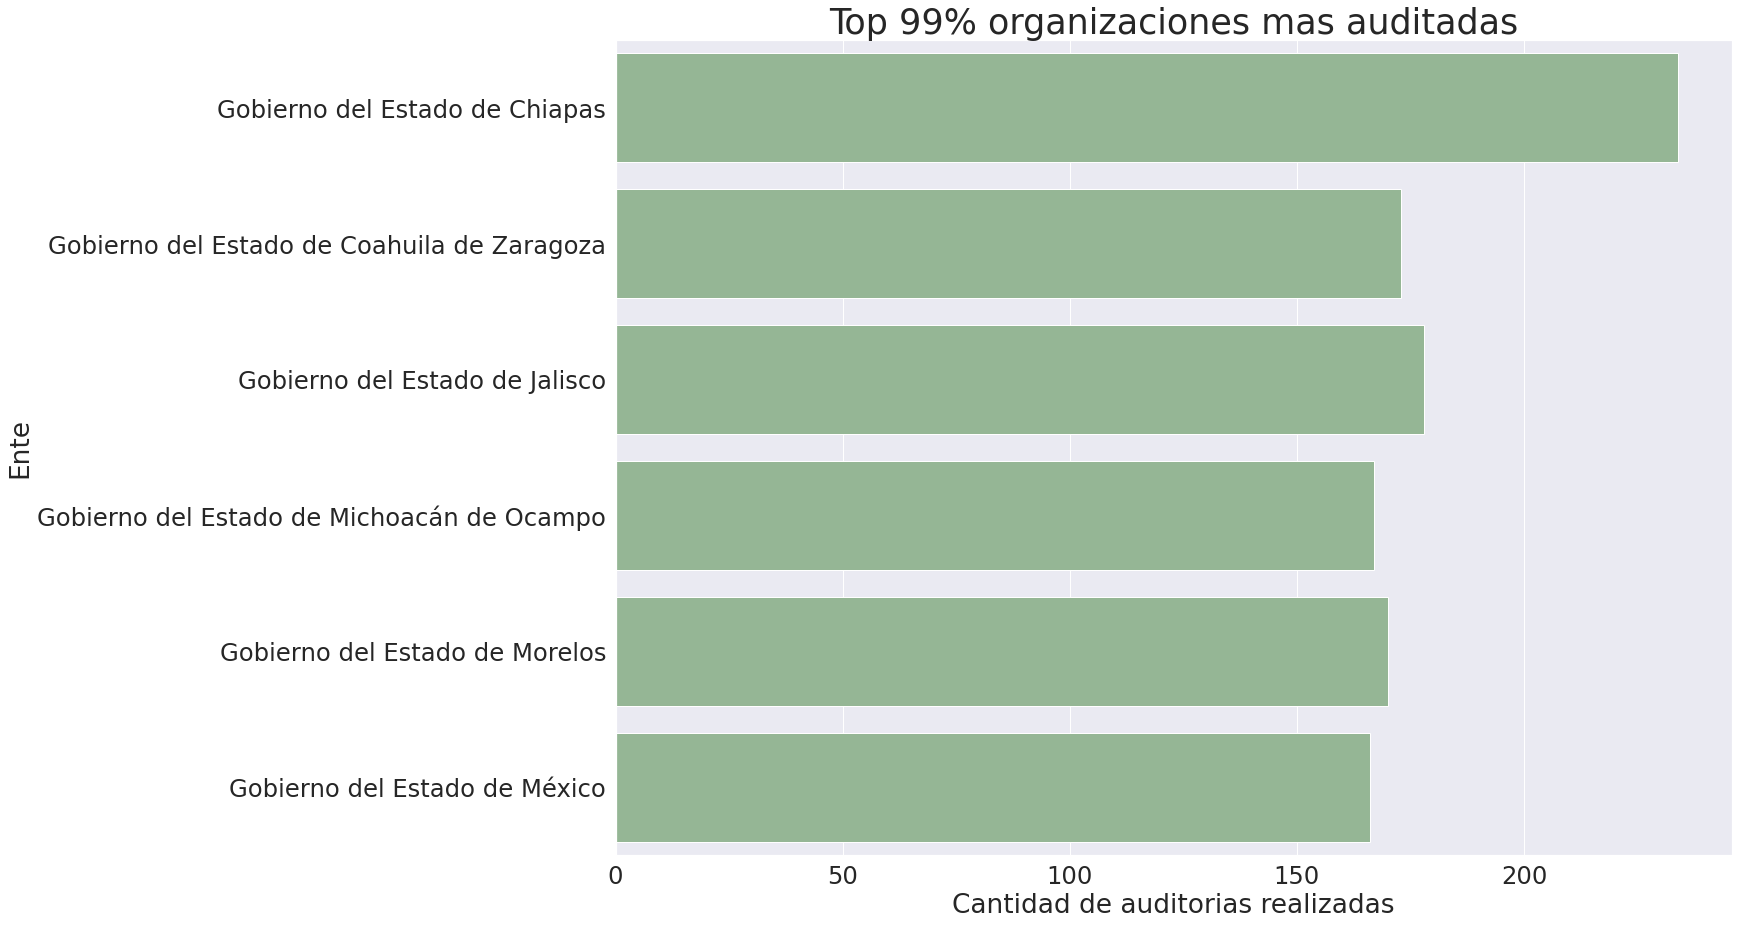

In [802]:
plt.figure(figsize=(20,15))
plt.title("Top 99% organizaciones mas auditadas",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Ente a quien se dirige la Acción", x="count", data = ds_top_99, color = "darkseagreen")
ax.set(
    xlabel = 'Cantidad de auditorias realizadas',
    ylabel='Ente'
)
# ax.ticklabel_format(axis="x", style = "sci",scilimits = (6,6))

## Cuales son los sectores peor administrados

In [812]:
ds_sector = ds_dinero.groupby('Sector')
ds_sector = ds_sector['desaparecido'].aggregate(['count', 'sum', 'mean'])
ds_sector = ds_sector.reset_index()
ds_sector

,Sector,count,sum,mean
0,Aportaciones A Seguridad Social,1,1.342933e+09,1.342933e+09
1,Cultura,16,1.645452e+08,1.028408e+07
2,Educación Pública,55,1.004372e+09,1.826132e+07
3,Hacienda y Crédito Público,126,4.295576e+09,3.409188e+07
4,Instituciones Públicas de Educación Superior,321,1.614851e+10,5.030688e+07
5,Previsiones y Aportaciones Para Los Sistemas d...,8,4.102477e+08,5.128096e+07
6,"Ramos Generales 23, 33 y Otros",5154,1.828826e+11,3.548363e+07
7,Salud,33,9.438853e+09,2.860258e+08
8,Seguridad y Protección Ciudadana,10,7.304049e+07,7.304049e+06


[Text(0.5, 0, 'Dinero promedio'), Text(0, 0.5, 'Ente')]

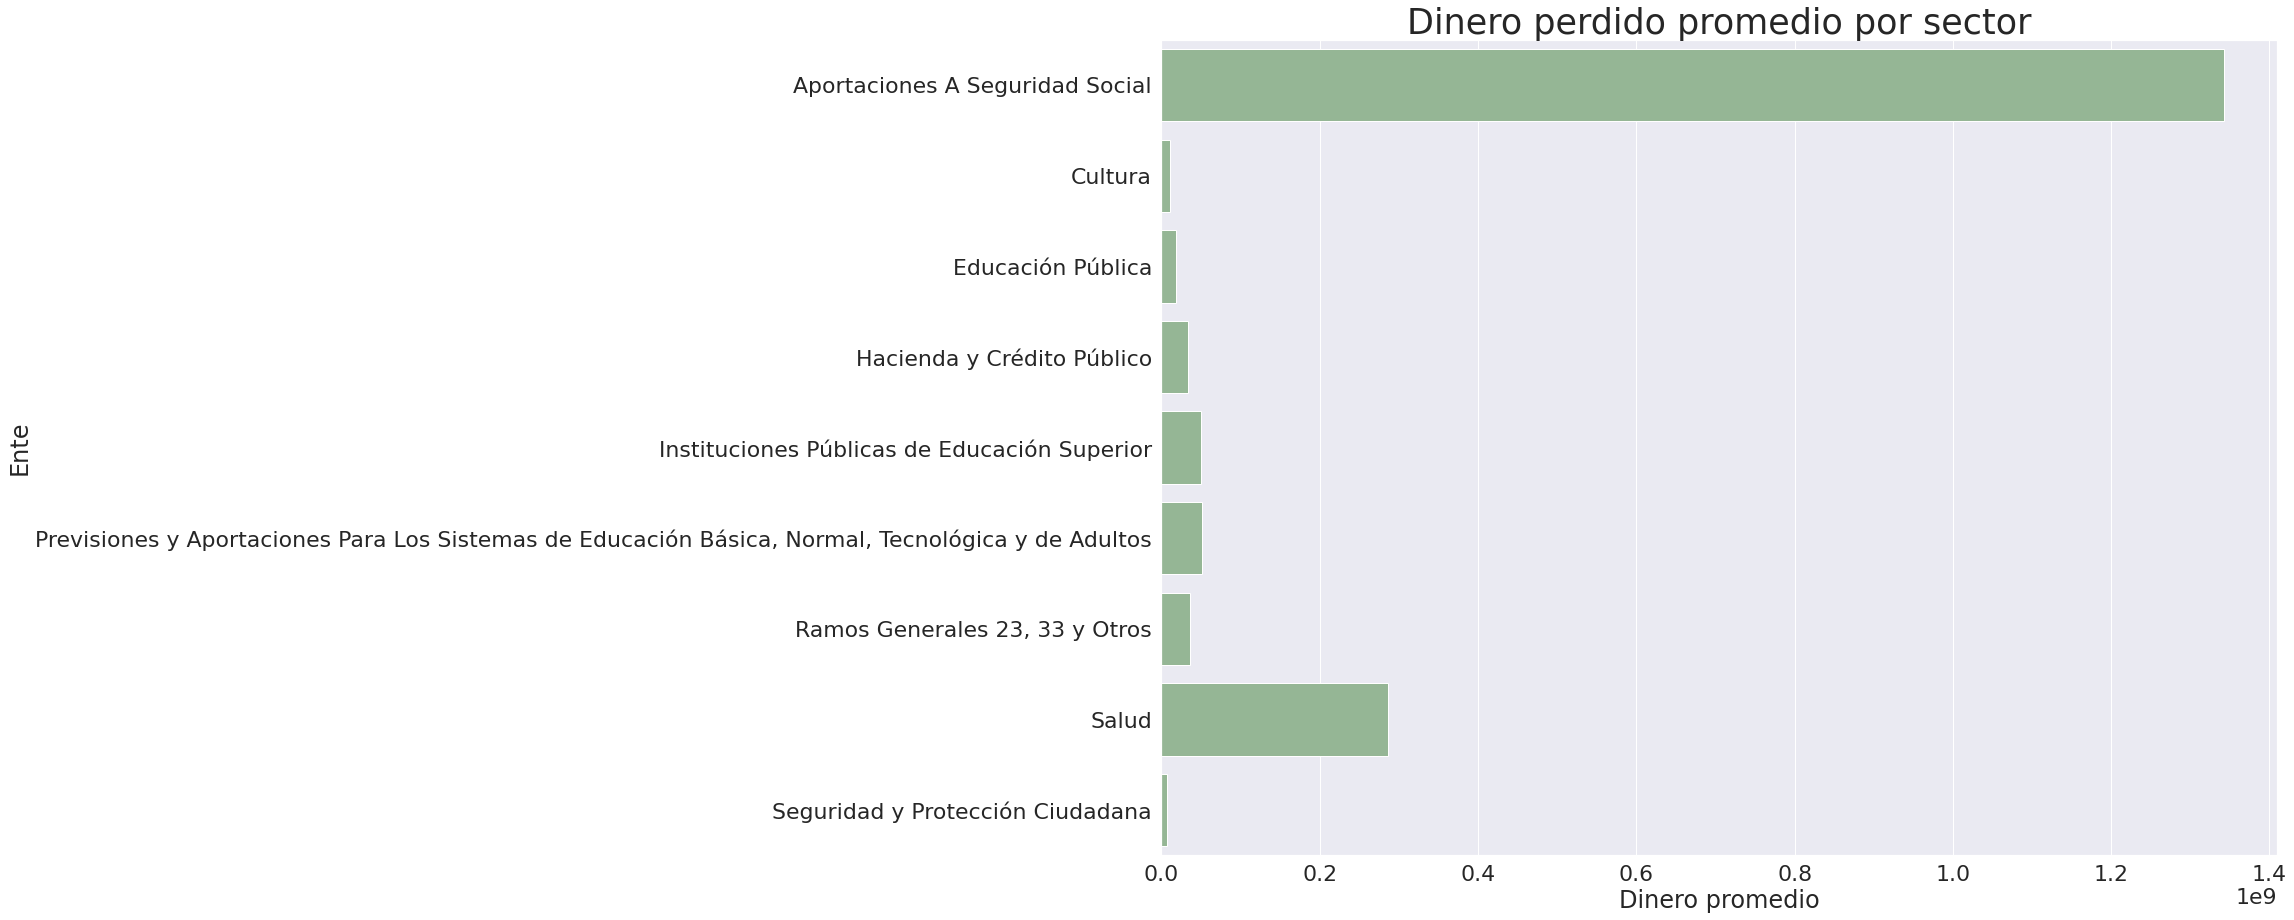

In [816]:
plt.figure(figsize=(20,15))
plt.title("Dinero perdido promedio por sector",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Sector", x="mean", data = ds_sector, color = "darkseagreen")
ax.set(
    xlabel = 'Dinero promedio',
    ylabel='Ente'
)

[Text(0.5, 0, 'Auditorias realizadas'), Text(0, 0.5, 'Ente')]

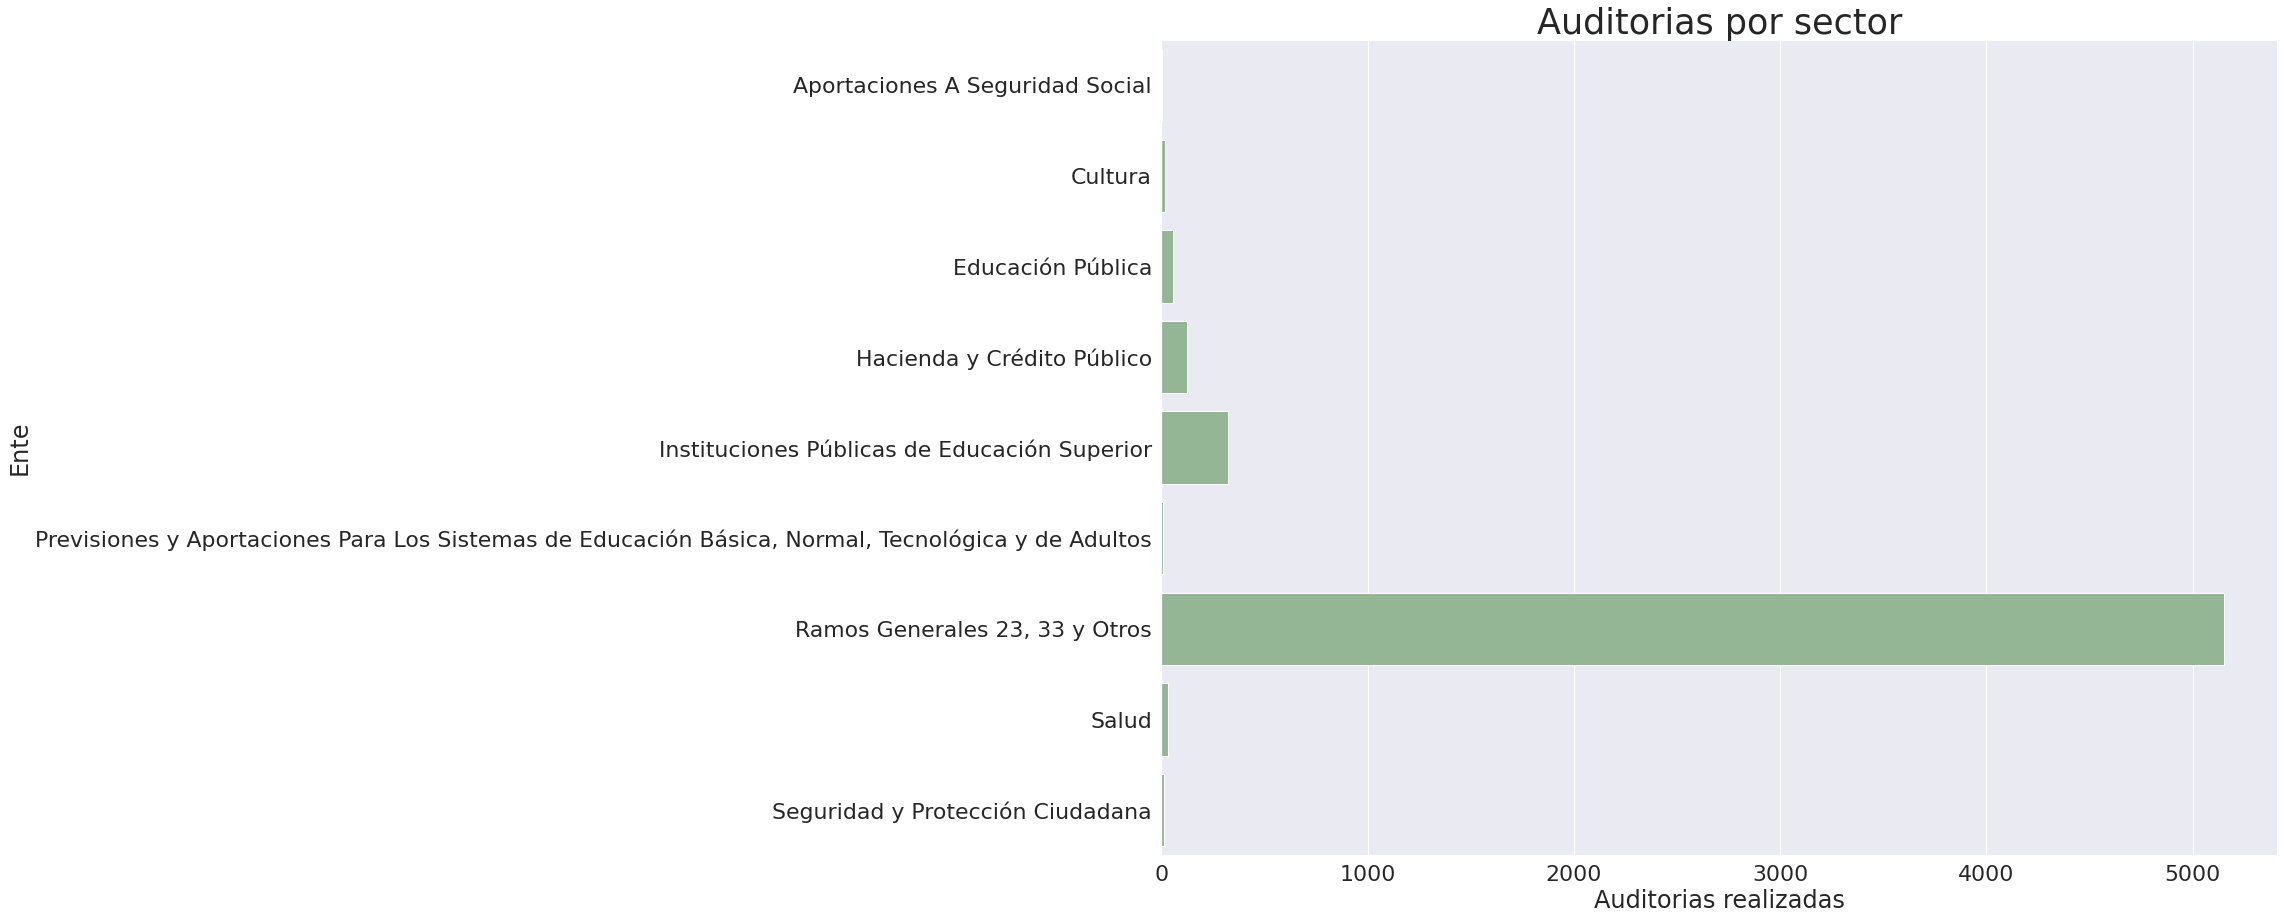

In [819]:
plt.figure(figsize=(20,15))
plt.title("Auditorias por sector",fontsize=35)
sns.set(font_scale=2)
ax = sns.barplot(y="Sector", x="count", data = ds_sector, color = "darkseagreen")
ax.set(
    xlabel = 'Auditorias realizadas',
    ylabel='Ente'
)